gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install cellpose

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [1]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
#from cellpose import models
#from cellpose.io import imread
#from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage import measure

In [2]:
import scipy
from scipy import ndimage as ndi
import cv2
from skimage.morphology import square, dilation
from sklearn.cluster import KMeans, DBSCAN
# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction

In [3]:
#cross validation with polynomial expansion
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
import statsmodels.formula.api as smf
import seaborn as sns
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

# Read csv

In [4]:
df = pd.read_csv ('../Features/TF1_A1.csv')
df = df.iloc[1: , :]


In [5]:
ypet_intensity = df.copy()

In [6]:
ypet_intensity['Circularity'] = (4*np.pi*ypet_intensity['patch_size'])/(ypet_intensity['Perimeter']**2)

***
# Preprocessing

### Outlier removal

To adapt is the columns where we want to change the outliers

In [7]:
columns_outliers = ['mean_intensity','patch_size']
remove_outliers = ypet_intensity.copy()

def outlier_removal(without_outliers, outlier_range = 4):
    columns_outliers= ['mean_intensity', 'median_intensity','sum_intensity','feret_diameter_max']    
    # Use a for loop to iterate over the columns of the dataframe
    for col in columns_outliers:
        # Look up the threshold value for the current column using the dictionary
        """
        median = without_outliers[col].median()
        q_75 = without_outliers[col].quantile(q = 0.75)
        q_25 = without_outliers[col].quantile(q = 0.25)
        interquantile = q_75 - q_25                              
        upper_bound = median + (interquantile * outlier_range)
        lower_bound = median - (interquantile * outlier_range)
        """
        q_95 = without_outliers[col].quantile(q = 0.99)
      # Create a boolean mask that is True for rows with a value less than or equal to the threshold
        #mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
        mask = without_outliers[col] <= q_95
      # Use the mask to filter the dataframe and keep only the rows with a value less than or equal to the threshold
        without_outliers = without_outliers[mask]
        
    return without_outliers


In [8]:
without_outliers = remove_outliers.groupby('TF_name',as_index=False).apply(outlier_removal).reset_index()
without_outliers = without_outliers.drop(['level_0'],axis=1)
without_outliers = without_outliers.set_index('level_1')
without_outliers.index.name = None

In [9]:
ypet_intensity_processed = without_outliers.copy()

In [12]:
#Add a name to the first column
colnames = list(ypet_intensity_processed)
colnames[0] = 'patch'
ypet_intensity_processed.columns = colnames


### Normalize ypet_intensity for each TF after we've concenated all df

In [10]:
# Normalize 
rows_to_be_normalized = list(ypet_intensity_processed)[7:]  #['mean_intensity', 'median_intensity', 'sum_intensity', 'feret_diameter_max']
TF_grouped = ypet_intensity_processed.groupby('TF_name')
Normalized_rows = TF_grouped[rows_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std())

# Replace normalized
ypet_intensity_processed[rows_to_be_normalized] = Normalized_rows

In [13]:
ypet_intensity_processed

,patch,img,fld,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
1,patch_0,0,1,A - 1,False,False,1643,0.154802,0.942537,0.014782,...,-0.490933,-0.253191,0.125831,-0.262425,-0.098555,-0.077659,0.163366,1.446642,-0.071726,-0.046620
2,patch_1,0,1,A - 1,False,False,1412,-0.196630,0.197311,-0.238766,...,-0.470038,1.102497,1.120409,-0.761177,-0.662307,-0.844522,-1.341129,-0.596425,0.820872,-0.271687
3,patch_2,0,1,A - 1,False,False,396,0.569748,-0.842270,0.531536,...,-0.170922,0.503005,1.077122,-0.313576,-0.099020,-0.531327,-1.618137,-1.473504,0.961911,1.228437
4,patch_3,0,1,A - 1,False,False,222,-0.157867,-1.293362,-0.361918,...,-0.435774,-0.859349,-0.097727,1.557034,0.001415,0.987004,-0.599673,-0.644650,-0.146805,1.979089
5,patch_4,0,1,A - 1,False,False,512,-0.247850,-0.955857,-0.172119,...,-0.220040,-0.847757,-0.486594,-0.281367,0.477008,0.563475,1.020407,-0.715482,-0.019460,1.150404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,patch_414,11,12,A - 1,False,False,1890,-0.899526,-0.247001,-0.895093,...,-0.192465,0.718072,1.295023,-0.698402,-1.050164,-0.722109,-1.242071,-0.318523,1.269502,0.414316
6524,patch_415,11,12,A - 1,False,False,1132,-0.715780,-0.617663,-0.704811,...,-0.314183,0.613871,0.039699,0.686931,-0.180234,-0.432441,-1.117111,0.357857,0.318193,0.084609
6525,patch_416,11,12,A - 1,False,False,1045,-0.708099,-0.685266,-0.698050,...,1.394113,0.703668,1.027045,-1.249866,-0.506004,-0.532182,-0.734329,-0.032638,0.393262,-1.042048
6526,patch_417,11,12,A - 1,False,False,963,-0.661405,-0.720037,-0.649755,...,-0.475285,-0.160729,0.137798,-0.626646,-0.222689,-0.284335,0.560900,1.687586,0.018803,-0.773678


***

# Task 1

In [14]:
# Split train test
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

testfeature = ['mean_intensity', 'sum_intensity', 'median_intensity','feret_diameter_max', 'Circularity']


df_train_x = df_train[['patch_size']]
df_test_x = df_test[['patch_size']]

df_train_y = df_train[[testfeature[2]]]
df_test_y = df_test[[testfeature[2]]]

"""
df_train_x = df_train[[testfeature[0]]]
df_test_x = df_test[[testfeature[0]]]

df_train_y = df_train[['patch_size']]
df_test_y = df_test[['patch_size']]
"""

"\ndf_train_x = df_train[[testfeature[0]]]\ndf_test_x = df_test[[testfeature[0]]]\n\ndf_train_y = df_train[['patch_size']]\ndf_test_y = df_test[['patch_size']]\n"

In [15]:
#model to select
maxdegree = 5 #To define is the maximum degree of the polynomial
cross_validation_ridge_error = np.zeros(maxdegree-1)
cross_validation_lm_error = np.zeros(maxdegree-1)

#see which degree fits data the best for linear regression
for d in range(1, maxdegree):
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
    #apply linear regression model and cross-validation for alpha-ridge regression
    lr = LinearRegression()
    rr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
    cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

In [16]:
index_min_lm = np.argmin(cross_validation_lm_error)
index_min_ridge = np.argmin(cross_validation_ridge_error)
x_poly_test = PolynomialFeatures(degree=index_min_lm+1).fit_transform(df_test_x)
x_poly_train = PolynomialFeatures(degree=index_min_lm+1).fit_transform(df_train_x)

x_poly_train_df = pd.DataFrame(x_poly_train)
x_poly_test_df = pd.DataFrame(x_poly_test)

#make linear model
model_lm = LinearRegression().fit(x_poly_train_df, df_train_y)
model_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df, df_train_y)

#train error
y_train_pred_lm = model_lm.predict(x_poly_train)
mse_train_lm = mean_squared_error(df_train_y,y_train_pred_lm)
y_train_pred_ridge = model_ridge.predict(x_poly_train)
mse_train_ridge = mean_squared_error(df_train_y,y_train_pred_ridge)

#test error
y_test_pred_lm = model_lm.predict(x_poly_test_df)
mse_test_lm = mean_squared_error(df_test_y,y_test_pred_lm)
y_test_pred_ridge = model_ridge.predict(x_poly_test_df)
mse_test_ridge = mean_squared_error(df_test_y,y_test_pred_ridge)

<AxesSubplot:xlabel='patch_size', ylabel='median_intensity'>

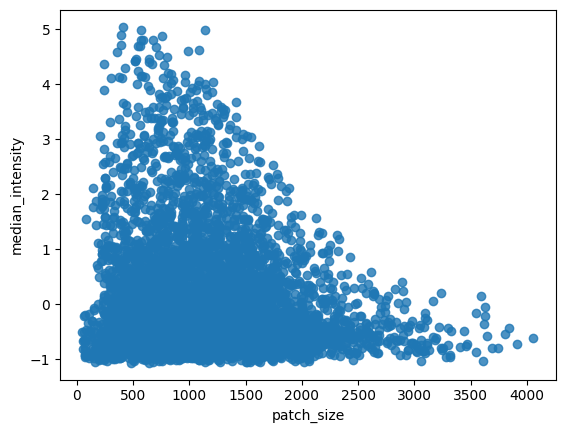

In [17]:
sns.regplot(x="patch_size", y="median_intensity", data=ypet_intensity_processed, fit_reg=False)

InvalidIndexError: (slice(None, None, None), None)

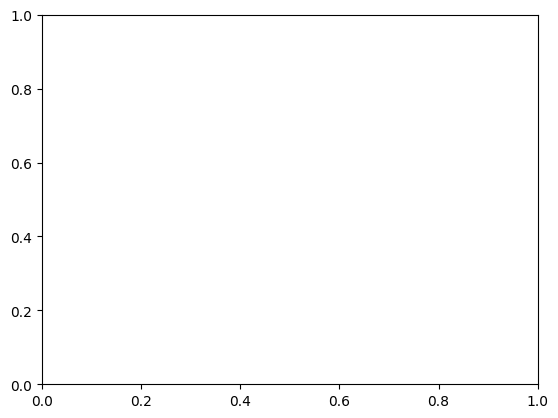

In [18]:
#show predicted things

plt.plot(df_train_x,df_train_y, 'ro')
plt.plot(df_test_x,y_test_pred_lm, 'ro',color = 'black')
"""
plt.plot(df_train_y,df_train_x, 'ro')
plt.plot(y_test_pred_lm,df_test_x, 'ro',color = 'black')
"""
#plt.yscale("log")
#plt.xscale("log")
plt.show()

C:\Users\Claudia\AppData\Local\Temp/ipykernel_12728/3888939154.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_test_x,y_test_pred_ridge, 'ro',color = 'black')


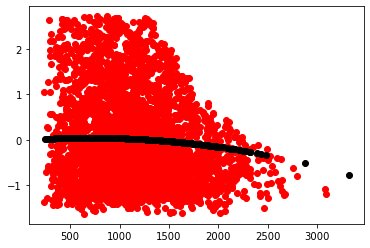

In [167]:
#show predicted things
plt.plot(df_train_x,df_train_y, 'ro')
plt.plot(df_test_x,y_test_pred_ridge, 'ro',color = 'black')

"""
plt.plot(df_train_y,df_train_x, 'ro')
plt.plot(y_test_pred_ridge,df_test_x, 'ro',color = 'black')
"""
#plt.yscale("log")
#plt.xscale("log")
plt.show()

In [168]:
if mse_test_ridge >= mse_test_lm:
    print('take linear regression')
    print('coefficients: ',model_lm.coef_)
    print('intercept: ',model_lm.intercept_)
    
else:
    print('take ridge regression')
    print('coefficients: ',model_ridge.coef_)
    print('intercept: ',model_ridge.intercept_)
    print('alpha: ',model_ridge.alpha_)

take linear regression
coefficients:  [[ 0.0000000e+00  1.6898442e-04 -2.2446335e-07]]
intercept:  [0.14208697]


In [145]:
ypet_intensity['Circularity'].max()

1.1303093159855457

***

## Task 2: Unsupervised clustering

Use pca or standard df

In [125]:
clustering_feature = ['patch_size', 'sum_intensity']
ypet_intensity[clustering_feature]

,patch_size,sum_intensity
patch_0,1100,29750097
patch_1,883,21733956
patch_2,1307,16564933
patch_3,2321,28482464
patch_4,900,45737457
patch_5,841,5246949


In [22]:
ypet_intensity_pca

,img,TF_name,pca_component_0,pca_component_1
patch_0,0,E - 7,4.975240e+07,-4.821806e+06
patch_1,0,E - 7,3.290267e+07,-9.583609e+06
patch_2,0,E - 7,-3.019646e+07,-2.059740e+06
patch_3,0,E - 7,-2.506924e+07,9.060520e+06
patch_4,0,E - 7,1.339753e+07,1.886480e+07
patch_5,0,E - 7,-4.078690e+07,-1.146016e+07


In [23]:
ypet_cluster = ypet_intensity_pca.reset_index().set_index(['index','img', 'TF_name'])
ypet_cluster

,,,pca_component_0,pca_component_1
index,img,TF_name,,
patch_0,0,E - 7,4.975240e+07,-4.821806e+06
patch_1,0,E - 7,3.290267e+07,-9.583609e+06
patch_2,0,E - 7,-3.019646e+07,-2.059740e+06
patch_3,0,E - 7,-2.506924e+07,9.060520e+06
patch_4,0,E - 7,1.339753e+07,1.886480e+07
patch_5,0,E - 7,-4.078690e+07,-1.146016e+07


In [24]:
from sklearn.cluster import KMeans

In [ ]:
random_state = 42
n_clusters = 5 #10 # Number of descriptions we want for TF
kmean = KMeans(n_clusters=n_clusters, random_state=random_state).fit(ypet_cluster)

ypet_clustered = ypet_cluster.copy()
ypet_clustered['cluster'] = kmean.labels_

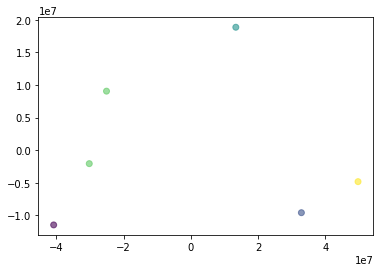

In [27]:
plt.scatter(ypet_cluster.iloc[:,0], ypet_cluster.iloc[:,1], c=kmean.labels_, alpha=0.6)

In [ ]:
# Find more information
min_n = ypet_clustered.groupby('cluster').count().min()[0] #min number of points i n a cluster
max_n = ypet_clustered.groupby('cluster').count().max()[0] #min number of points i n a cluster
min_n, max_n

In [112]:
# Extract x percentage of data per cluster -> easier to analyze

extracted_i = []
x = 0.9

for i in range(n_clusters):

    # indices of all the points from X that belong to cluster i
    C_i = np.where(kmean.labels_ == i)[0].tolist() 
    n_i = len(C_i) # number of points in cluster i

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i, math.ceil((x * n_i))).tolist()
    extracted_i.extend(sample_i) 
    

In [122]:
ypet_clustered.iloc[np.unique(extracted_i)]

,,,pca_component_0,pca_component_1,cluster
index,img,TF_name,,,
patch_0,0,E - 7,4.975240e+07,-4.821806e+06,4
patch_1,0,E - 7,3.290267e+07,-9.583609e+06,1
patch_2,0,E - 7,-3.019646e+07,-2.059740e+06,3
patch_3,0,E - 7,-2.506924e+07,9.060520e+06,3
patch_4,0,E - 7,1.339753e+07,1.886480e+07,2
patch_5,0,E - 7,-4.078690e+07,-1.146016e+07,0


***
# Visualizations (Exploration phase)

#### Tune blur

plt.imshow(cv2.Laplacian(variance_data_list[test], cv2.CV_64F), cmap='gray')


for i in range(1,100), image E-7

Not blurred:
variance_data_list[-1] -> 1'763'695
variance_data_list[-10] -> 3'056'590
variance_data_list[-10] -> 3'056'590
[-17] -> 1'056'899
[-20] -> 567'588
[-21] -> 2'138'449
[-23] -> 5'134'705
[-33] 30'821'019


Right classified with other nucleus near:
variance_data_list[-6] -> 25'095'309
variance_data_list[-13] ->5'698'016
[-16] -> 9'219'300
[-19] -> 11'049'582
[-25] -> 2'313'727
[-26] -> 157'114'853
[-27] -> 10'010'503
[-28] -> 3'063'935
[-31] -> 1'803'048
9'826'707


Wrongly classified:
variance_data_list[-6] -> 25'095'309
variance_data_list[-9] -> 57'898'307
[-14] -> 21'739'451
[-15] -> 6'769'331
[-30] -> 12'627'256


Overlay:
variance_data_list[-4] -> 34'614'946
[-22] -> 12'964'725
[-29] -> 17'727'949

Blurr/ overflow:
[-18] -> 283'062'008
[-24] -> 17'935'490

In [254]:
cv2.Laplacian(variance_data_list[test], cv2.CV_64F).var()

77809334.92977796

In [293]:
measure.blur_effect(variance_data_list[test])

0.4792840663960735

#### Mask, nucleus

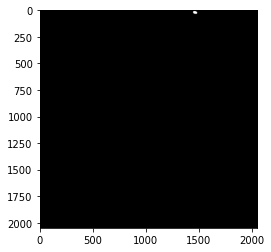

In [305]:
plt.imshow(boolean, cmap='gray')

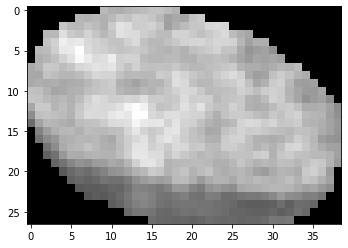

In [313]:
plt.imshow(patch_data, cmap='gray')

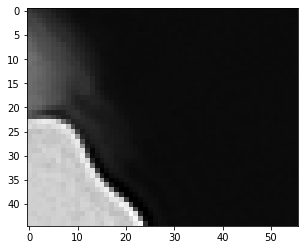

In [292]:
test = 31
plt.imshow(variance_data_list[test], cmap='gray')

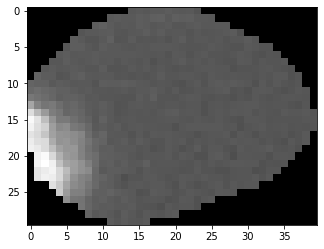

In [225]:
plt.imshow(patch_data_list[test], cmap='gray')

## Local binary patterns

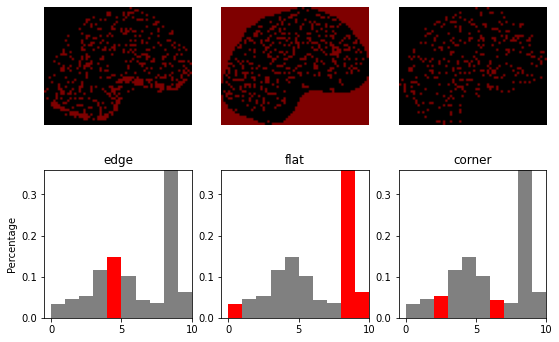

In [142]:
# Visualize lpb
METHOD = 'uniform'   
radius = 1
n_points = 8 * radius
image = patch_data

lbp = local_binary_pattern(image, n_points, radius, METHOD)

    
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')



<BarContainer object of 8 artists>

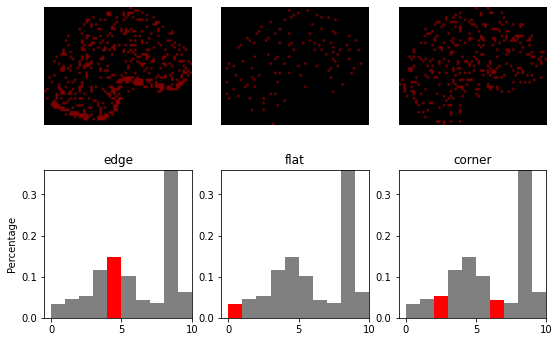

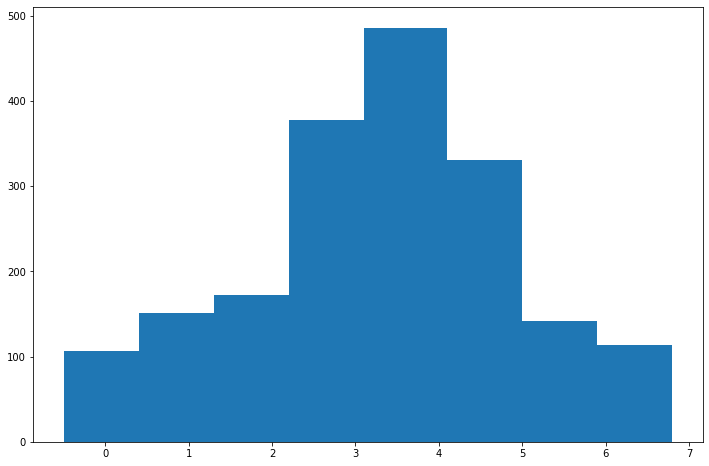

In [143]:
# Remove background    

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) # Remove background: list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)



for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)   
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

# Drop background
count = len(np.unique(lbp))
H, bins = np.histogram(lbp, count)

# Drop background values
fig, ax = plt.subplots(figsize=(12, 8))
index_background = n_points - w
H = H[0: index_background]
bins =  bins[0: index_background]

plt.bar(bins,H,width=1)